In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import itertools

In [3]:
class TdCARS:
    """
    Class to simulate Time-Delayed Coherent Anti-Stokes Raman Scattering (TdCARS).
    Version 1.0
    """
    def __init__(self,l1,l2,tp1,tp2,tp3,tmin,tmax,floor,nuR1,T21,A1,phi1):
        """
        Initializes the TdCARS class with given parameters.
        l1, l2 : Wavelengths of pump and Stokes pulses [nm]
        tp1, tp2, tp3 : Pulse durations of pump, Stokes, and probe [fs]
        tmin, tmax : Time delay range [fs]
        floor : Baseline signal level
        nuR1 : List of Raman shift frequency [cm^-1]
        T21 : List of Dephasing time [fs]
        A1 : List of Amplitudes of Raman modes [au]
        """
        self.c = 2.99792e10  # speed of light [cm/s]
        self.l1 = l1
        self.l2 = l2
        self.nuR1 = nuR1
        self.tp1 = tp1
        self.tp2 = tp2
        self.tp3 = tp3
        self.tmin = tmin
        self.tmax = tmax
        self.floor = floor
        self.T21 = T21
        self.A1 = A1
        self.phi1 = phi1
        w1 = 1e7 * 2 * np.pi * self.c / self.l1
        w2 = 1e7 * 2 * np.pi * self.c / self.l2
        self.wt = w1 - w2
        wR1 = 2 * np.pi * self.nuR1 * self.c
        self.wr1 = (self.wt - wR1) * 1e-15
        self.nut = self.wt / (2 * np.pi * self.c)
    
    def CARS_simulation_FG(self):
        """
        Simulates Coherent Anti-Stokes Raman Scattering (CARS) signal.

        Returns:
        td : Time delay array [fs]
        signal : Simulated CARS signal array [a.u.]
        """
        # ---------------------------------------------------------
        # Constants & Input Parameters
        # ---------------------------------------------------------
        norm = 1e-15  # [fs] to [s] conversion factor

        a12 = -2 * np.log(2) * (1/self.tp1**2 + 1/self.tp2**2)

        b21 = -1/self.T21 - 1j*self.wr1

        # ---------------------------------------------------------
        # Time grid
        # ---------------------------------------------------------
        step0 = 5
        step1 = 5
        t1 = np.arange(self.tmin, self.tmax, step1)
        m1 = len(t1)

        lim = 5 * self.tp1
        ts = np.arange(-lim, lim, step0)

        Q = np.zeros(m1, dtype=complex)

        # ---------------------------------------------------------
        # Main integration loop
        # ---------------------------------------------------------
        for j1, t in enumerate(t1):

            if t < -lim:
                hs = np.zeros_like(ts)
            elif t > lim:
                hs = np.ones_like(ts)
            else:
                p1 = int(round((t + lim) / step0))
                hs = np.concatenate((np.ones(p1), np.zeros(len(ts) - p1)))
            #hs = np.heaviside(t-ts,1)
            F1 = hs * (
                self.A1[0] * np.exp(b21[0] * (t - ts) + self.phi1) +
                self.A1[1] * np.exp(b21[1] * (t - ts))
            ) * np.exp(a12 * ts**2)

            Q[j1] = step0 * np.trapezoid(F1)

        Q11 = (norm * np.abs(Q))**2

        # ---------------------------------------------------------
        # Convolution with probe pulse
        # ---------------------------------------------------------
        a3 = -4 * np.log(2) / self.tp3**2
        step2 = 5

        td = np.arange(self.tmin + 5*self.tp3, self.tmax - 5*self.tp3 + step2, step2)
        m2 = len(td)

        signal = np.zeros(m2)

        for j2 in range(m2):
            I3 = np.sqrt(-a3/np.pi) * np.exp(a3 * (t1 - td[j2])**2)
            F2 = Q11 * I3
            signal[j2] = norm * step2 * np.trapezoid(F2) + self.floor

        return td, signal
    
    @staticmethod
    def import_experimental_data(filepath):
        """
        Imports experimental CARS data from a CSV file.
        The CSV file should have 4 columns: time delay (fs), signal (a.u.)., int_signal(a.u.) and attenuation(a.u.)
        filepath : Path to the CSV file
        Returns:
        td_exp : Time delay array from experimental data [fs]
        signal_exp : CARS signal array from experimental data [a.u.]
        int_signal : Integrated signal array from experimental data [a.u.]
        attenuation : Attenuation values array from experimental data [a.u.]
        """
        data = np.loadtxt(filepath, delimiter='\t')
        td_exp = data[:,0]
        signal_exp = data[:,1]
        int_signal = data[:,2]
        attenuation = data[:,3]
        return td_exp, signal_exp, int_signal, attenuation
    
    @staticmethod
    def correct_experimental_data(signal_exp, attenuation, corrections):
        """
        Corrects the experimental CARS signal for incorrect attenuations.
        signal_exp : Experimental CARS signal [a.u.]
        attenuation : list of attenuation values [a.u.]
        corrections : 2D array of attenuation corrections [[old1,new1],[old2,new2],...]
        Returns:
        signal_exp_corrected : Corrected experimental CARS signal [a.u.]
        """
        att_exp = attenuation.copy()
        att_bofr = np.append(corrections[:,0],[ x * y for x, y in itertools.combinations(corrections[:,0], 2)])
        att_aftr = np.append(corrections[:,1],[ x * y for x, y in itertools.combinations(corrections[:,1], 2)])
        for i in range(len(att_bofr)):
            att_exp[att_exp == att_bofr[i]] = att_aftr[i]
        signal_exp_corrected = signal_exp/attenuation*att_exp
        return signal_exp_corrected
    
    @staticmethod
    def show_notes(cars_file_path):
        """
        Displays the notes associated with the CARS data file.
        cars_file_path : Path to the CARS data file
        Returns:
        df : DataFrame containing the notes
        """
        cars_notes_file_path = cars_file_path[:-4]+"_Notes.dat"
        df = pd.read_csv(cars_notes_file_path, sep="\t")
        return df
    
    @staticmethod
    def get_T2(td_exp, signal_exp_corrected, td1, td2, show_plot=False):
        """
        Estimates the dephasing time T2 from the experimental CARS data.
        td_exp : Time delay array from experimental data [fs]
        signal_exp_corrected : Corrected CARS signal from experimental data [a.u.]
        td1, td2 : Time delay range for fitting [fs]
        show_plot : If True, displays the fitting plot
        Returns:
        T2 : Estimated dephasing time [fs]
        dT2 : Uncertainty in the estimated dephasing time [fs]
        """
        x = td_exp[(td_exp>=td1) & (td_exp<=td2)]
        y = np.log(signal_exp_corrected[(td_exp>=td1) & (td_exp<=td2)])
        (m, b), cov = np.polyfit(x, y, 1, cov=True)
        dm = 2*np.sqrt(cov[0, 0])  # uncertainty in slope 95% confidence interval
        T2, dT2 = -2/m, 2*dm/m**2
        if show_plot:
            fig = plt.figure(figsize=(10,5))
            plt.subplot(121)
            plt.semilogy(td_exp, signal_exp_corrected, 'ko', mfc='none', label='All Transient Data')
            plt.semilogy(x, np.exp(y), 'bo', mfc='none', label='Decay Data')
            plt.xlabel('Time Delay (fs)')
            plt.ylabel('CARS Signal (a.u.)')
            plt.title('CARS Signal: Experimental Data')
            plt.legend()
            plt.subplot(122)
            plt.plot(x,y,'bo', mfc='none', label='Data for Linear Fit')
            plt.plot(x, m*x + b, 'r-', label='Linear Fit'+r", slope={:.0f}±{:.0f} fs".format(-2/m,2*dm/m**2))
            plt.plot(x, (m+dm)*x + b, 'r--', label='+2σ')
            plt.plot(x, (m-dm)*x + b, 'r--', label='-2σ')
            plt.xlabel('Time Delay (fs)')
            plt.ylabel('ln(CARS Signal)')
            plt.title('Logarithmic Decay Fit')
            plt.legend()
            plt.show()
        return T2, dT2

In [4]:
cars_file_path = r"D:\Academic\URI\Research\Data_and_Results\experimental_data\2024\CARS\Aug_07\LNB_1.dat"

td_exp, signal_exp, int_signal, attenuation = TdCARS.import_experimental_data(cars_file_path)


corrections = np.array([[120,100], [650,500], [30,30]])
signal_exp_corrected = TdCARS.correct_experimental_data(signal_exp, attenuation, corrections)

TdCARS.show_notes(cars_file_path)

,DET,Syncerity CCD
0,SMP,LNB
1,P3 (TiS),140
2,P1 (OPO1),200
3,P2 (OPO2),220
4,Polarizations,All parallel
5,Ti-Sa,815.8
6,OPO1,1016.8
7,OPO2,1114.2
8,MONO,757
9,Slit,0.35


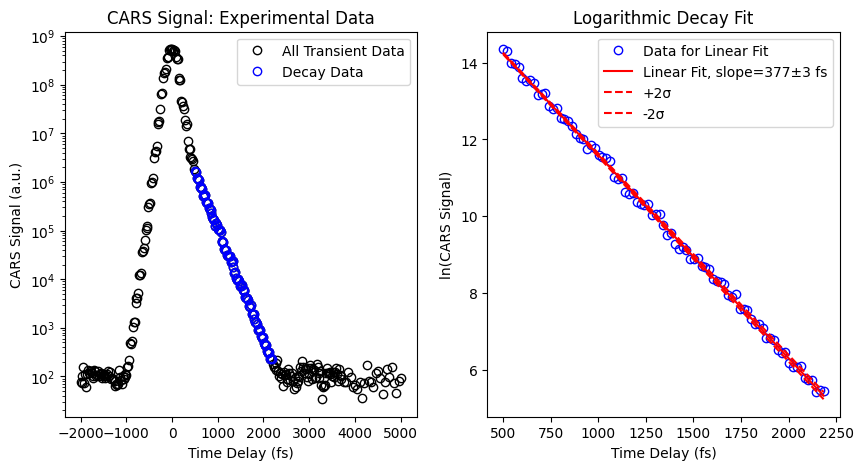

In [5]:
td1,td2 = 500,2200 #Time delay range for fitting [fs]
T2, dT2 = TdCARS.get_T2(td_exp, signal_exp_corrected, td1, td2, show_plot=True)

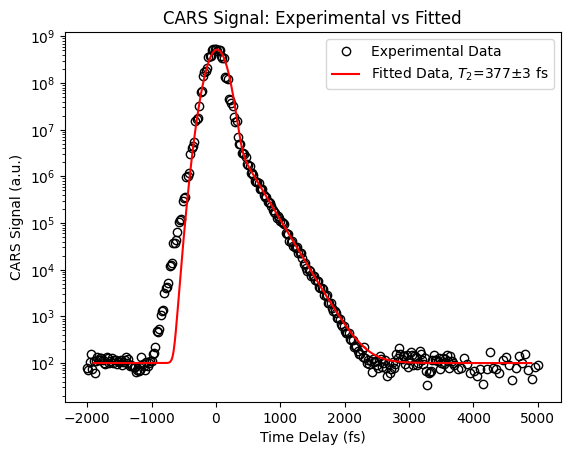

In [6]:
wl1,wl2 = 1016.8,1114.2  # Pump and Stokes wavelengths [nm]
tp1,tp2,tp3 = 260,260,220  # Pulse durations [fs]
tmin,tmax = -3000,6000  # Time delay range [fs]
floor = 100  # Baseline signal level
nuR1 = np.array([730,800])  # Raman shift frequencies [cm^-1]
T21 = np.array([T2,300])  # Dephasing times [fs]
A1 = np.array([1.9e25,0])  # Amplitudes of Raman modes [au]
phi1 = 0  # Phase of first Raman mode [rad]

CARS = TdCARS(wl1,wl2,tp1,tp2,tp3,tmin,tmax,floor,nuR1,T21,A1,phi1)
td_fit, signal_fit = CARS.CARS_simulation_FG()

plt.semilogy(td_exp, signal_exp_corrected, 'ko', mfc='none', label='Experimental Data')
plt.semilogy(td_fit, signal_fit, 'r-', label='Fitted Data, '+r"$T_2$={:.0f}$\pm${:.0f}".format(T21[0],dT2)+" fs")
plt.xlabel('Time Delay (fs)')
plt.ylabel('CARS Signal (a.u.)')
plt.title('CARS Signal: Experimental vs Fitted')
plt.legend()
plt.show()

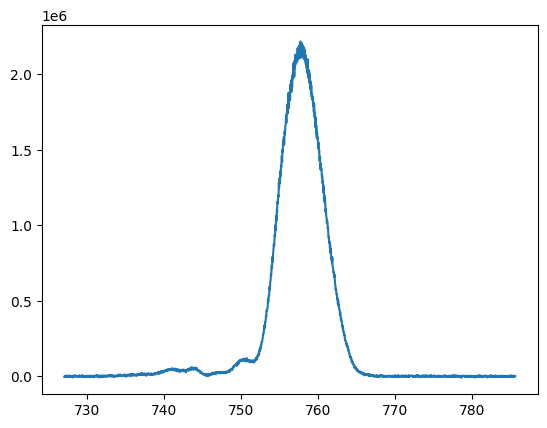

In [25]:
cars_file_path = r"D:\Academic\URI\Research\Data_and_Results\experimental_data\2024\CARS\Aug_07\LNB_1.dat"

#Read notes file
cars_notes_file_path = cars_file_path[:-4]+"_Notes.dat"
df = pd.read_csv(cars_notes_file_path, sep="\t",header=None)

# Extract parameters from notes
sample = df.loc[df[0] == 'SMP'][1].tolist()[0]
wl3 = float(df.loc[df[0] == 'Ti-Sa'][1].tolist()[0])
wl1 = float(df.loc[df[0] == 'OPO1'][1].tolist()[0])
wl2 = float(df.loc[df[0] == 'OPO2'][1].tolist()[0])
mono = float(df.loc[df[0] == 'MONO'][1].tolist()[0])
spectral_window = [float(x) for x in df.loc[df[0] == 'Spectral window (px)'][1].tolist()[0].split(' to ')]
notes_version = float(df.loc[df[0] == 'Version'][1].tolist()[0])

# Read spectra and floor data files
cars_spectra_file_path = cars_file_path[:-4]+"_Spectra.dat"
cars_floor_file_path = cars_file_path[:-4]+"_Floor.dat"
spectra_data = np.loadtxt(cars_spectra_file_path, delimiter='\t')
cars_floor = np.loadtxt(cars_floor_file_path, delimiter='\t')
td_arr = spectra_data[:,0]
attSpectra = spectra_data[:,1]
rawSpectra = spectra_data[:,2:]

rCnt,cCnt = len(rawSpectra[:,0]),len(rawSpectra[0,:])
att2d = np.zeros([rCnt,cCnt])
floor2d = np.zeros([rCnt,cCnt])
curr_att = 1
curr_floor_idx = 0
for i in range(rCnt):
    if not curr_att == attSpectra[i]:
        curr_att = attSpectra[i]
        curr_floor_idx += 1
    else:
        pass
    att2d[i,:] = np.ones(cCnt)*curr_att
    floor2d[i,:] = cars_floor[curr_floor_idx,:]

spectra = np.multiply((rawSpectra-floor2d),att2d)

def px2wl(px):
    """
    Converts pixel to wavelength[nm].

    Parameters
    ----------
    px : int or numpy.ndarray
        The pixel value.

    Returns
    -------
    float or numpy.ndarray
        The wavelength value in nm.
    """
    gd=1200#grating density[groves/mm]
    cs=2048#chip size
    ps=14e-3#pixel spacing [mm]
    c1 = np.radians(10.63*2)/2
    a = np.arcsin((mono*gd*1e-6)/(np.cos(c1)*2)) - c1
    b = a + np.radians(10.63*2) + np.radians(-5.5)
    h = np.sin(np.radians(-5.5))*318.719
    l = np.cos(np.radians(-5.5))*318.719
    m = b-np.arctan(((((cs/2)-px+1)*ps)+h)/l)
    (np.sin(m)+np.sin(a))*(1000000/gd)
    return (np.sin(m)+np.sin(a))*(1000000/gd)


td = 100 # time delay [fs]

for td in [500]:
    spectra_at_td = spectra[np.where(td_arr >= td)[0][0],:]
    #spectra_at_td = spectra_at_td/np.max(spectra_at_td)
    plt.plot(px2wl(np.arange(2048)), spectra_at_td)

np.int64(105)